In [1]:
%matplotlib inline
from pylab import *

- it's remarkable how little effect the jitter has on the speed of the deficit and the recovery, except hampering the recovery at extreme values.

In [2]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.7
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


In [3]:
def mydisplay(t,sim,neurons,connections):
    global _fig
    from IPython.display import display, clear_output
    from pylab import figure,close,gcf
    try:
        clear_output(wait=True)

        _fig=pn.utils.plot_rfs_and_theta(sim,neurons,connections)
        _fig.suptitle("%.2f" % (t/hour))
        display(_fig)
        close(_fig)
    except KeyboardInterrupt:
        close(_fig)
        raise


In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2023-01-05'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

In [6]:
base_image_file='asdf/bbsk081604_all.asdf'

In [7]:
def blur_jitter_deficit(blur=[2.5,-1],
                        noise=[0.1,.1],
                        rf_size=19,eta=2e-6,
                        mu_c=0,sigma_c=0,    
                        mu_r=0,sigma_r=0,
                        number_of_neurons=10,
                        total_time=8*day,
                        save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    dt=200*ms
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'log2dog','sd1':1,'sd2':3},
                                    )
        images.append(im)
        
        
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                buffer_c=mu_c+2*sigma_c,
                                                buffer_r=mu_r+2*sigma_r,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


In [8]:
def fix_jitter(noise=0.1,rf_size=19,
           number_of_neurons=10,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,
           total_time=8*day,
           save_interval=1*hour,
           eta=2e-6):
    
    if _debug:
        total_time=1*minute
        save_interval=1*second

    im=pi5.filtered_images(
                        base_image_file,
                        {'type':'log2dog','sd1':1,'sd2':3},
                        )
    
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                buffer_c=mu_c+2*sigma_c,
                                                buffer_r=mu_r+2*sigma_r,
                                                verbose=False)
    pre2=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)


    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


In [9]:
rf_size=19
eta=2e-6
sigma_c=1
blur=10
mu_c=13
open_eye_noise=0.1
number_of_neurons=5
number_of_processes=4

seq=pn.Sequence()

t=16*day
ts=1*hour

# DEBUG
if _debug:
    t=1*minute
    ts=1*second

seq+=blur_jitter_deficit(blur=[blur,-1],
                            total_time=t,
                            noise=open_eye_noise,
                            eta=eta,number_of_neurons=number_of_neurons,
                            mu_c=mu_c,sigma_c=sigma_c,
                            save_interval=ts)



Using cache_images/cache_images_2d4973998e95890cd68475879c02e51f.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.

In [10]:
%%time
try:
    seq.run(display=None,display_hash=False,
               time_between_display=10*hour)
    #seq.run(display_hash=False)    
except KeyboardInterrupt:
    close()
    


[.] Sequence Time Elapsed...3 m, 56.50 s
CPU times: user 3min 54s, sys: 1.44 s, total: 3min 55s
Wall time: 3min 56s


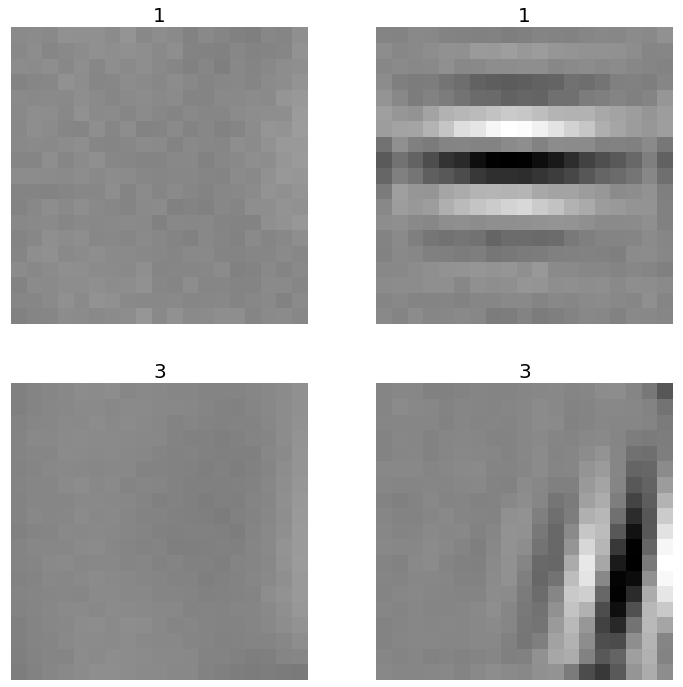

In [36]:
which_neurons=[1,3]
sim,neurons,connections=seq.sims[0],seq.neurons[0],seq.connections[0]


pre,post=neurons
c=connections[0]

weights=c.weights

num_neurons=len(weights)

if which_neurons is None:
    which_neurons=list(range(num_neurons))

N=len(which_neurons)

nr=int(ceil(sqrt(N)))
nc=int(ceil(N/nr))

fig1=figure(figsize=(12,12))
ni=0
for i,w in enumerate(weights):
    if i not in which_neurons:
        continue

    try:  # check for channel
        neurons=pre.neuron_list
    except AttributeError:
        neurons=[pre]

    num_channels=len(neurons)

    count=0
    vmin,vmax=w.min(),w.max()
    for c,ch in enumerate(neurons):   
        try:
            rf_size=ch.rf_size
            if rf_size<0:
                rf_size=py.sqrt(ch.N)
                assert rf_size==int(rf_size)
                rf_size=int(rf_size)

        except AttributeError:
            rf_size=py.sqrt(ch.N)
            assert rf_size==int(rf_size)
            rf_size=int(rf_size)


        py.subplot(nr,nc*num_channels,2*ni+c+1)
        py.axis('equal')
        py.grid(False)
        subw=w[count:(count+rf_size*rf_size)]
        #py.pcolor(subw.reshape((rf_size,rf_size)),cmap=py.cm.gray)
        py.pcolormesh(subw.reshape((rf_size,rf_size)),cmap=py.cm.gray,
            vmin=vmin,vmax=vmax)
        py.xlim([0,rf_size]); 
        py.ylim([0,rf_size])
        py.axis('off')
        count+=rf_size*rf_size
        py.title(i)

    ni+=1

In [37]:
t,θ=sim.monitors['theta'].arrays()

In [38]:
θ.shape

(385, 5)

In [39]:
len(θ)

385

In [41]:
import matplotlib.ticker

def HMSFormatter(value, loc):
    h = value // 3600
    m = (value - h * 3600) // 60
    s = value % 60

    d=h//24
    h=h%24
    if d==0:
        return "%02d:%02d:%02d" % (h,m,s)
    else:
        return "%dd %02d:%02d:%02d" % (d,h,m,s)

def HMSFormatter2(value, loc):
    h = value // 3600
    m = (value - h * 3600) // 60
    s = value % 60
    ms=value%1

    return "%02d:%02d.%03d" % (m,s,ms*1000)

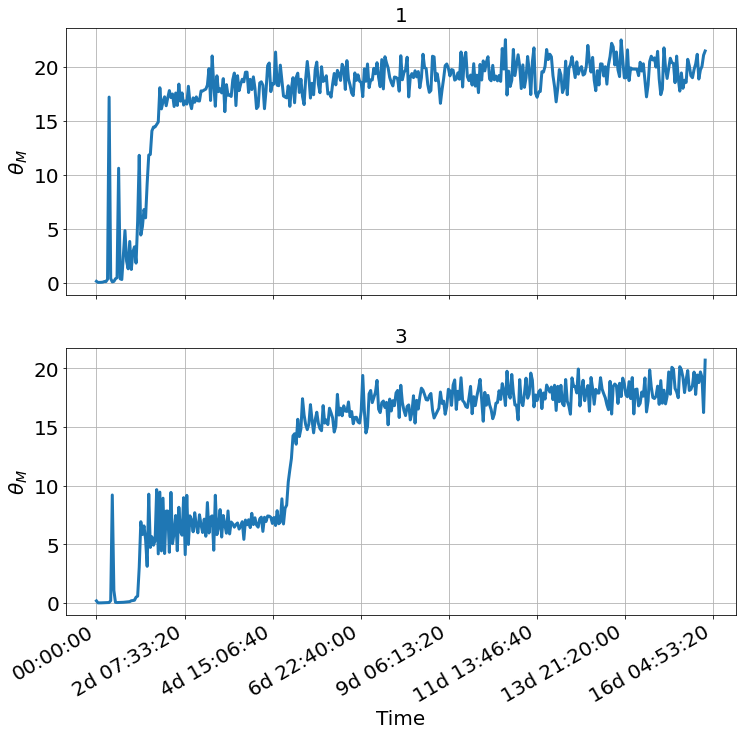

In [44]:
t,θ=sim.monitors['theta'].arrays()

fig2=figure(figsize=(12,12))
ni=0
for i in range(num_neurons):
    if i not in which_neurons:
        continue

    py.subplot(nr,nc,ni+1)
    py.plot(t,θ[:,i])
    
    if ni%nc==0:
        py.ylabel(r'$\theta_M$')
    if ni//nc==(nr-1):
        py.xlabel('Time')
    else:
        gca().set_xticklabels([])
    py.title(i)

    if np.max(t)<10:  # use ms
        py.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(HMSFormatter2))
    else:
        py.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(HMSFormatter))    
    
    
    ni+=1        
        
fig2.autofmt_xdate()        
    

In [55]:
def plot_rfs_and_theta2(sim,neurons=None,connections=None,which_neurons=None):
    
    
    import matplotlib.ticker

    def HMSFormatter(value, loc):
        h = value // 3600
        m = (value - h * 3600) // 60
        s = value % 60

        d=h//24
        h=h%24
        if d==0:
            return "%02d:%02d:%02d" % (h,m,s)
        else:
            return "%dd %02d:%02d:%02d" % (d,h,m,s)

    def HMSFormatter2(value, loc):
        h = value // 3600
        m = (value - h * 3600) // 60
        s = value % 60
        ms=value%1

        return "%02d:%02d.%03d" % (m,s,ms*1000)    

    if neurons is None:  # sim is a seq
        seq=sim
        
        Lseq=len(seq.sims)
        sim,neurons,connections=seq.sims[-1],seq.neurons[-1],seq.connections[-1]

    
    pre,post=neurons
    c=connections[0]

    weights=c.weights

    num_neurons=len(weights)

    if which_neurons is None:
        which_neurons=list(range(num_neurons))

    N=len(which_neurons)

    nr=int(ceil(sqrt(N)))
    nc=int(ceil(N/nr))

    fig1=figure(figsize=(12,12))
    ni=0
    for i,w in enumerate(weights):
        if i not in which_neurons:
            continue

        try:  # check for channel
            neurons=pre.neuron_list
        except AttributeError:
            neurons=[pre]

        num_channels=len(neurons)

        count=0
        vmin,vmax=w.min(),w.max()
        for c,ch in enumerate(neurons):   
            try:
                rf_size=ch.rf_size
                if rf_size<0:
                    rf_size=py.sqrt(ch.N)
                    assert rf_size==int(rf_size)
                    rf_size=int(rf_size)

            except AttributeError:
                rf_size=py.sqrt(ch.N)
                assert rf_size==int(rf_size)
                rf_size=int(rf_size)


            py.subplot(nr,nc*num_channels,2*ni+c+1)
            py.axis('equal')
            py.grid(False)
            subw=w[count:(count+rf_size*rf_size)]
            #py.pcolor(subw.reshape((rf_size,rf_size)),cmap=py.cm.gray)
            py.pcolormesh(subw.reshape((rf_size,rf_size)),cmap=py.cm.gray,
                vmin=vmin,vmax=vmax)
            py.xlim([0,rf_size]); 
            py.ylim([0,rf_size])
            py.axis('off')
            count+=rf_size*rf_size
            py.title(i)

        ni+=1

    t,θ=sim.monitors['theta'].arrays()

    fig2=figure(figsize=(12,12))
    ni=0
    for i in range(num_neurons):
        if i not in which_neurons:
            continue

        py.subplot(nr,nc,ni+1)
        py.plot(t,θ[:,i])

        if ni%nc==0:
            py.ylabel(r'$\theta_M$')
        if ni//nc==(nr-1):
            py.xlabel('Time')
        else:
            gca().set_xticklabels([])
        py.title(i)

        if np.max(t)<10:  # use ms
            py.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(HMSFormatter2))
        else:
            py.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(HMSFormatter))    


        ni+=1        

    fig2.autofmt_xdate()        
      

    return fig1,fig2

(<Figure size 864x864 with 10 Axes>, <Figure size 864x864 with 5 Axes>)

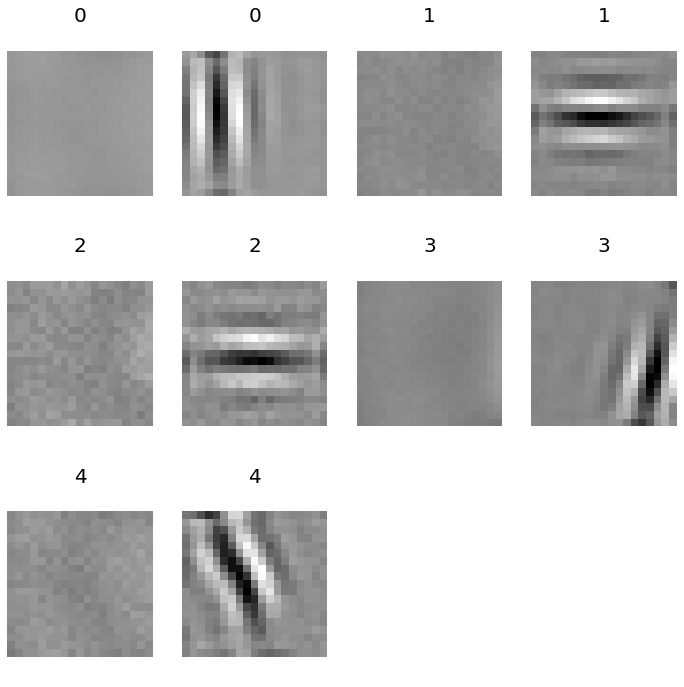

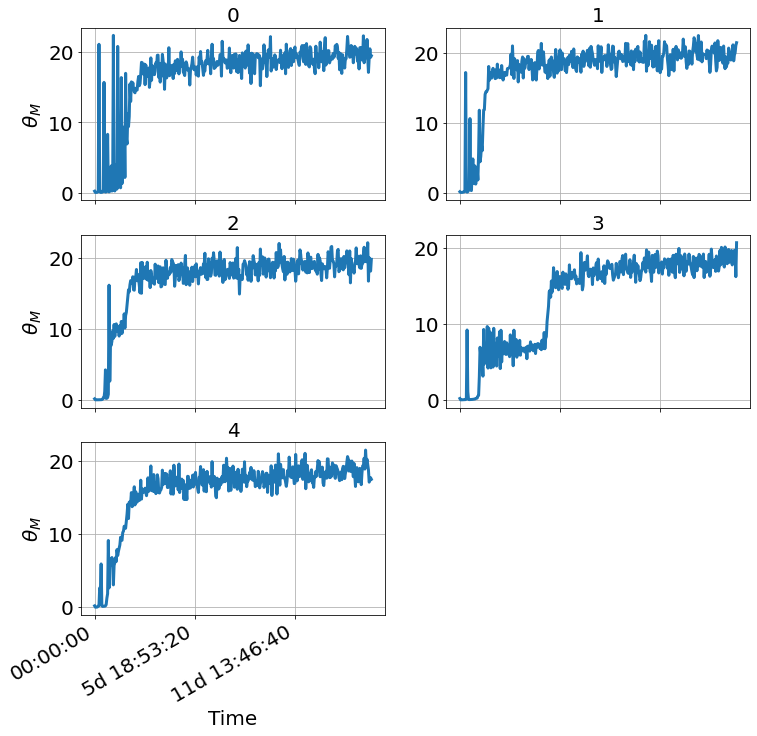

In [56]:
plot_rfs_and_theta2(seq.sims[0],seq.neurons[0],seq.connections[0])

(<Figure size 864x864 with 10 Axes>, <Figure size 864x864 with 5 Axes>)

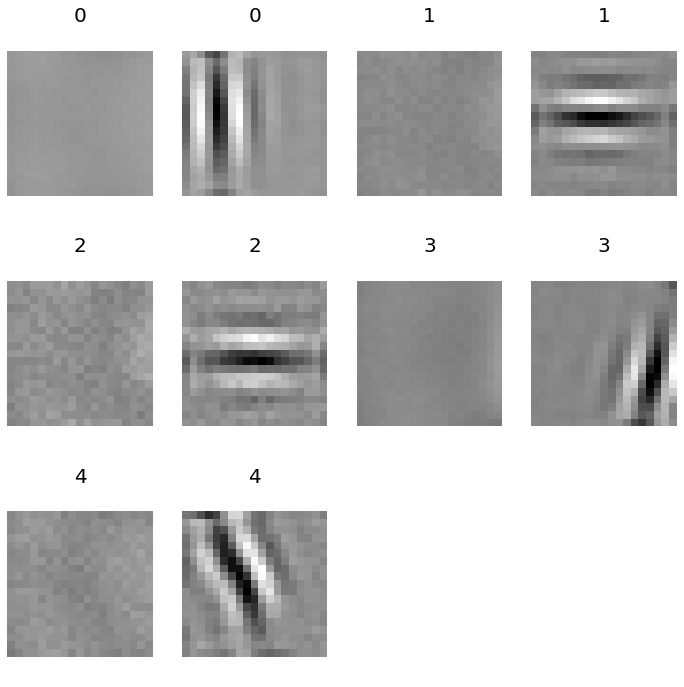

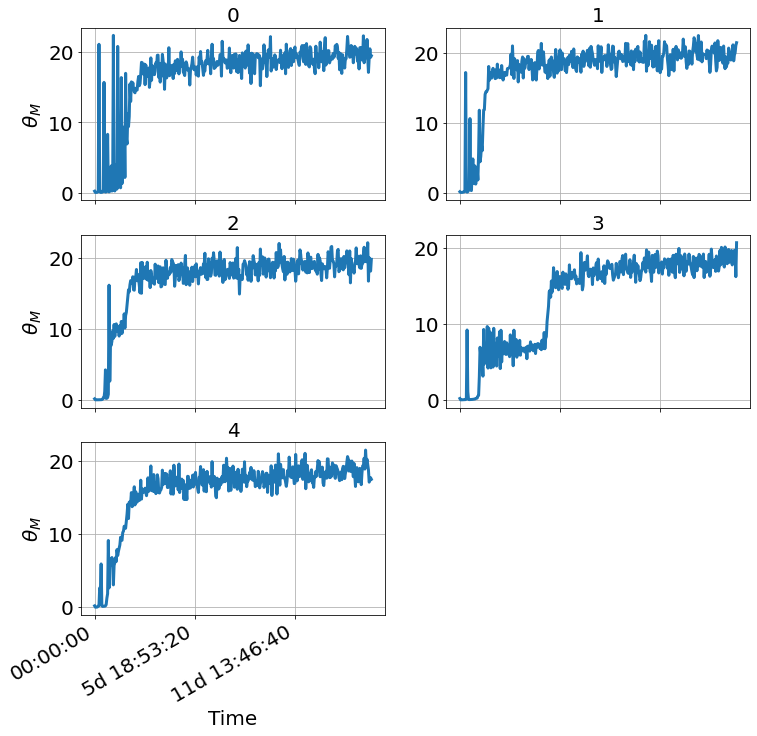

In [57]:
plot_rfs_and_theta2(seq)

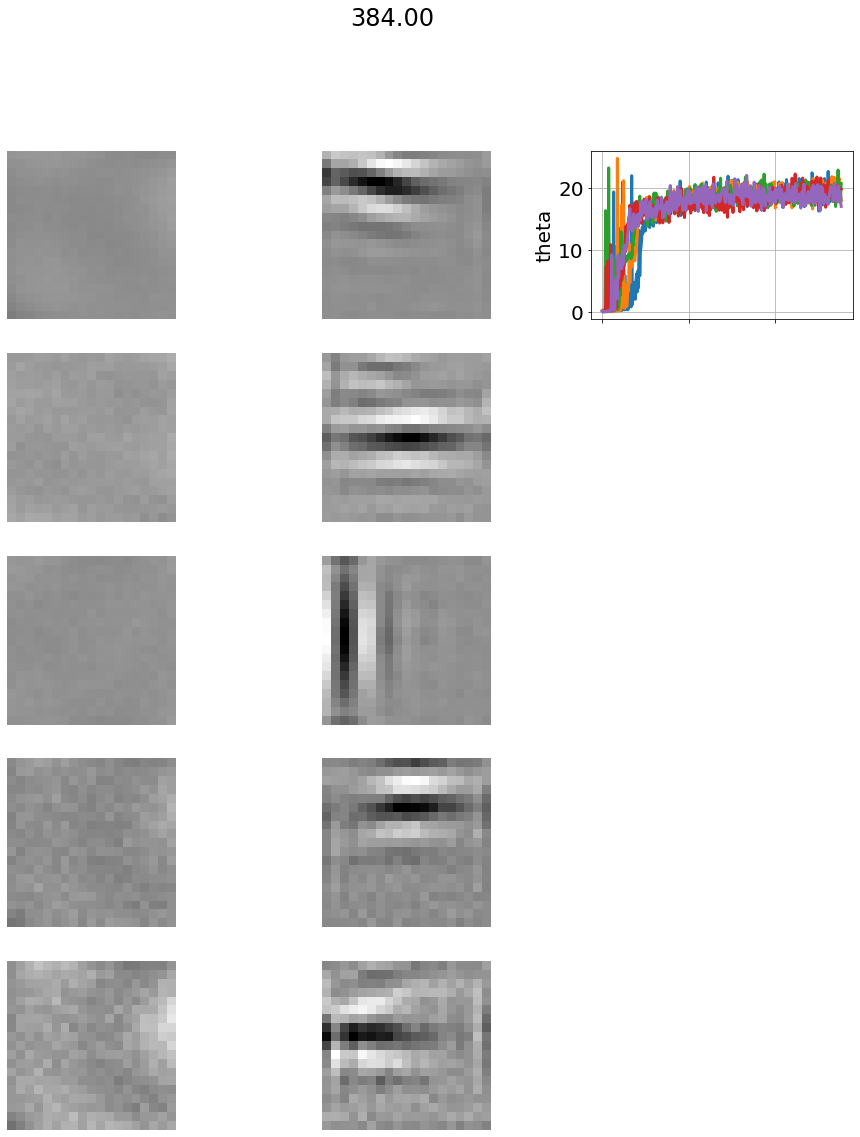

In [61]:
mydisplay(t,seq.sims[0],seq.neurons[0],seq.connections[0])

In [103]:
seq2=pn.Sequence()


seq2.load_seq(seq)

t=10*day
ts=0.5*hour

# DEBUG
if _debug:
    t=1*minute
    ts=1*second

seq2+=fix_jitter(total_time=t,
       save_interval=ts,
        mu_c=mu_c,sigma_c=sigma_c,
         eta=eta,noise=open_eye_noise,
                 number_of_neurons=number_of_neurons)
    


Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.

In [104]:
try:
    seq2.run(display=None,display_hash=False,
               time_between_display=10*hour)
except KeyboardInterrupt:
    close()
    


[..] Sequence Time Elapsed...47.79 s


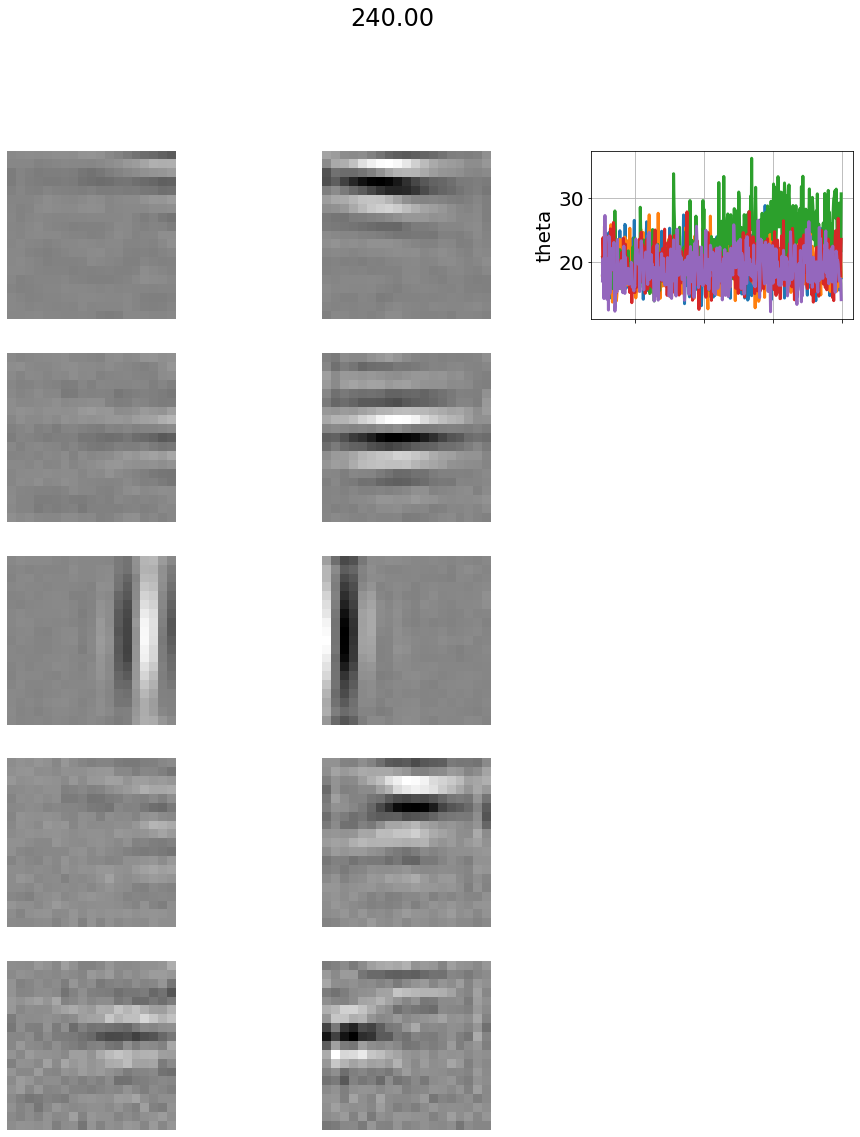

In [105]:
mydisplay(t,seq2.sims[-1],seq2.neurons[-1],seq2.connections[-1])

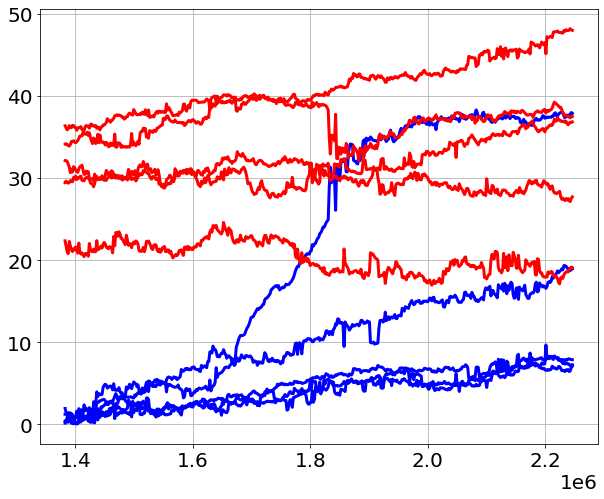

In [106]:
fname='sims/2023-01-05/test.asdf'
pn.save(fname,seq2)
R=Results(fname)

result=R.get_max_responses()
idx=R.t>seq.sims[0].total_time

plot(R.t[idx],R.y[idx,:,0],'b-')
plot(R.t[idx],R.y[idx,:,1],'r-');

In [122]:
seq2=pn.Sequence()


seq2.load_seq(seq)

seq2+=fix_jitter(total_time=t,
       save_interval=ts,
        mu_c=0,sigma_c=0,
         eta=eta,noise=.1,number_of_neurons=number_of_neurons)
    


Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.

In [123]:
try:
    seq2.run(display=None,display_hash=False,
               time_between_display=10*hour)
except KeyboardInterrupt:
    close()
    


[..] Sequence Time Elapsed...41.73 s


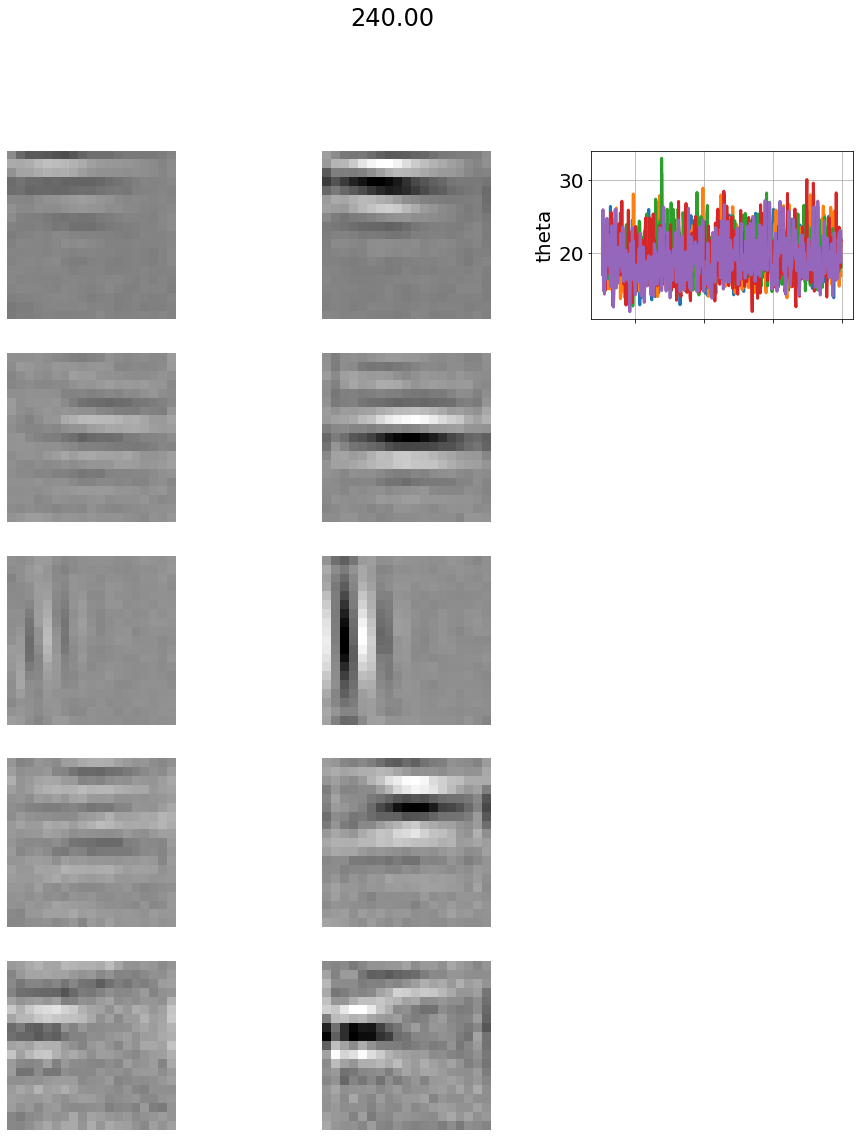

In [124]:
mydisplay(t,seq2.sims[-1],seq2.neurons[-1],seq2.connections[-1])

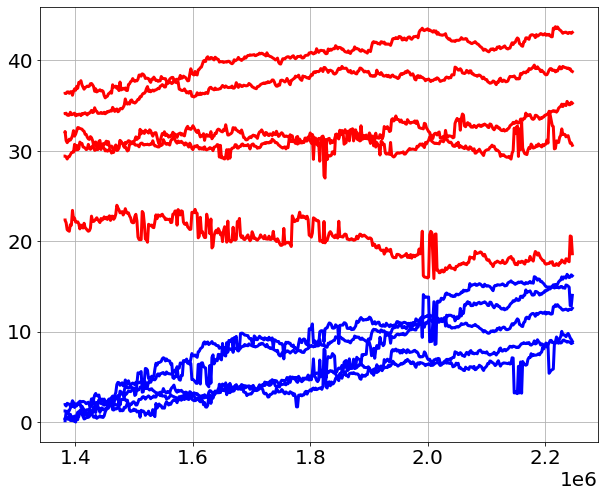

In [125]:
fname='sims/2023-01-05/test.asdf'
pn.save(fname,seq2)
R=Results(fname)

result=R.get_max_responses()
idx=R.t>seq.sims[0].total_time

plot(R.t[idx],R.y[idx,:,0],'b-')
plot(R.t[idx],R.y[idx,:,1],'r-');

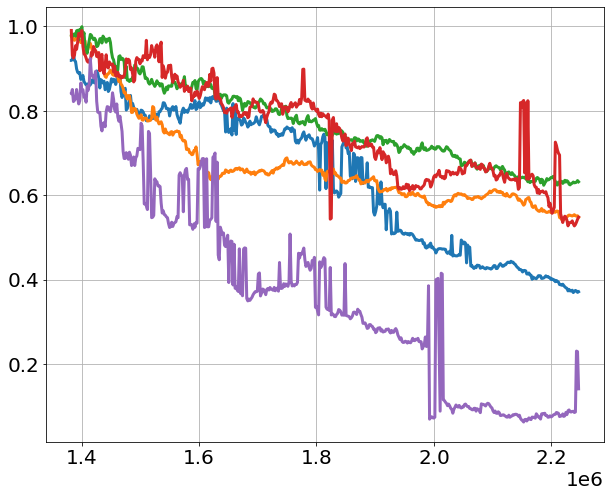

In [126]:
plot(R.t[idx],R.ODI[idx,:]);

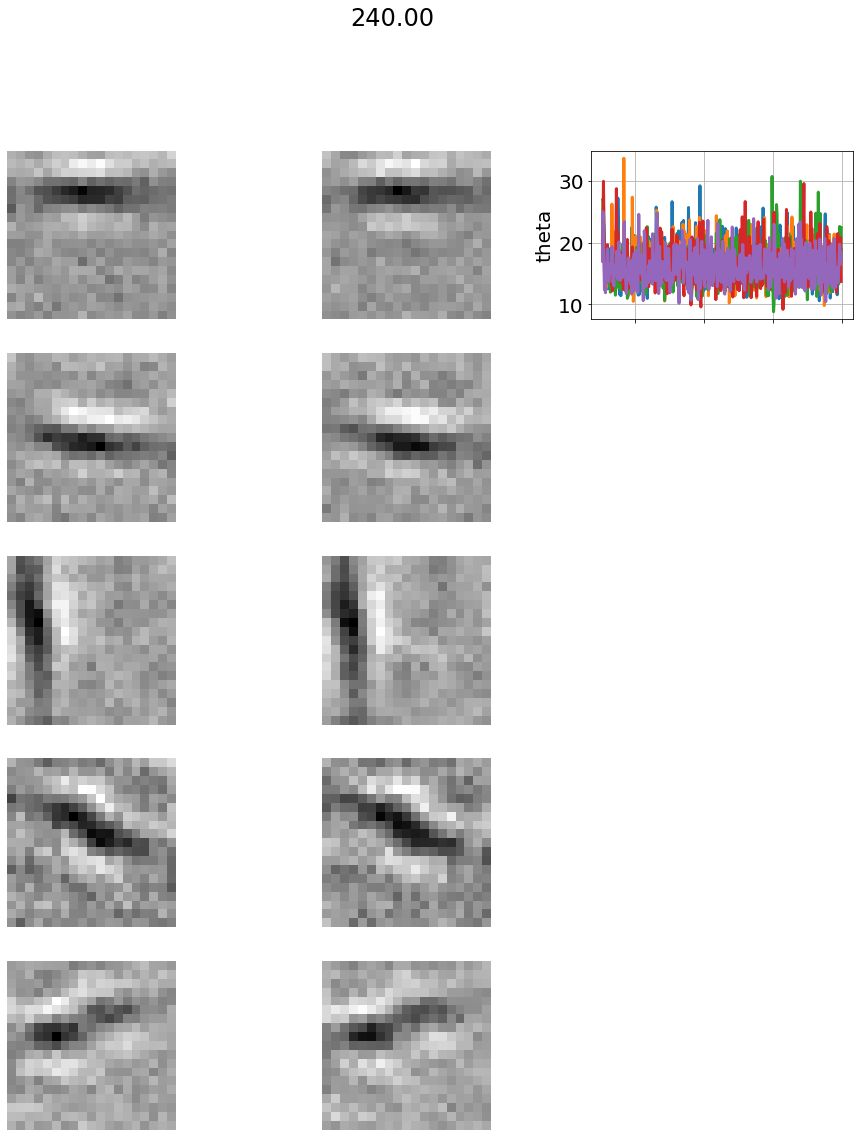

In [111]:
seq2=pn.Sequence()


seq2.load_seq(seq)

seq2+=fix_jitter(total_time=t,
       save_interval=ts,
        mu_c=0,sigma_c=0,
         eta=eta,noise=1,number_of_neurons=number_of_neurons)
    
try:
    seq2.run(display=None,display_hash=False,
               time_between_display=10*hour)
except KeyboardInterrupt:
    close()
    

mydisplay(t,seq2.sims[-1],seq2.neurons[-1],seq2.connections[-1])
    

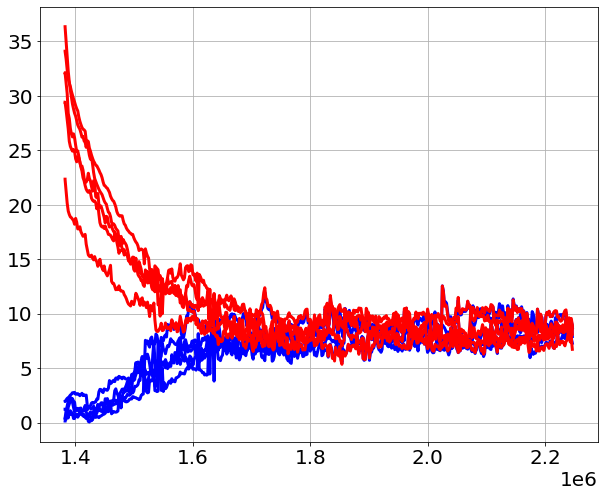

In [112]:
fname='sims/2023-01-05/test.asdf'
pn.save(fname,seq2)
R=Results(fname)

result=R.get_max_responses()
idx=R.t>seq.sims[0].total_time

plot(R.t[idx],R.y[idx,:,0],'b-')
plot(R.t[idx],R.y[idx,:,1],'r-');

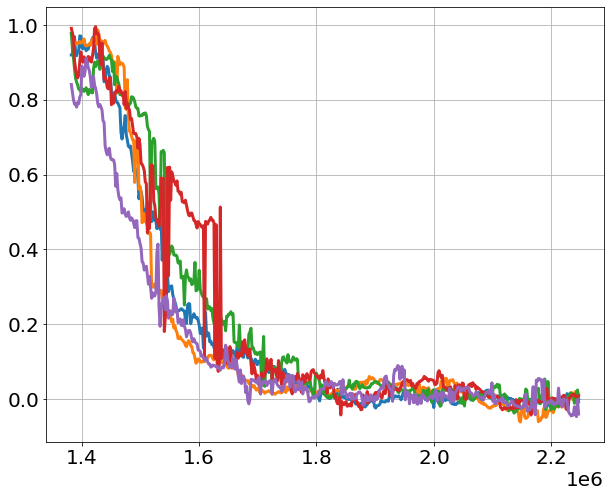

In [121]:
plot(R.t[idx],R.ODI[idx,:]);

## explore mu_c

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.81 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.68 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.67 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.48 s


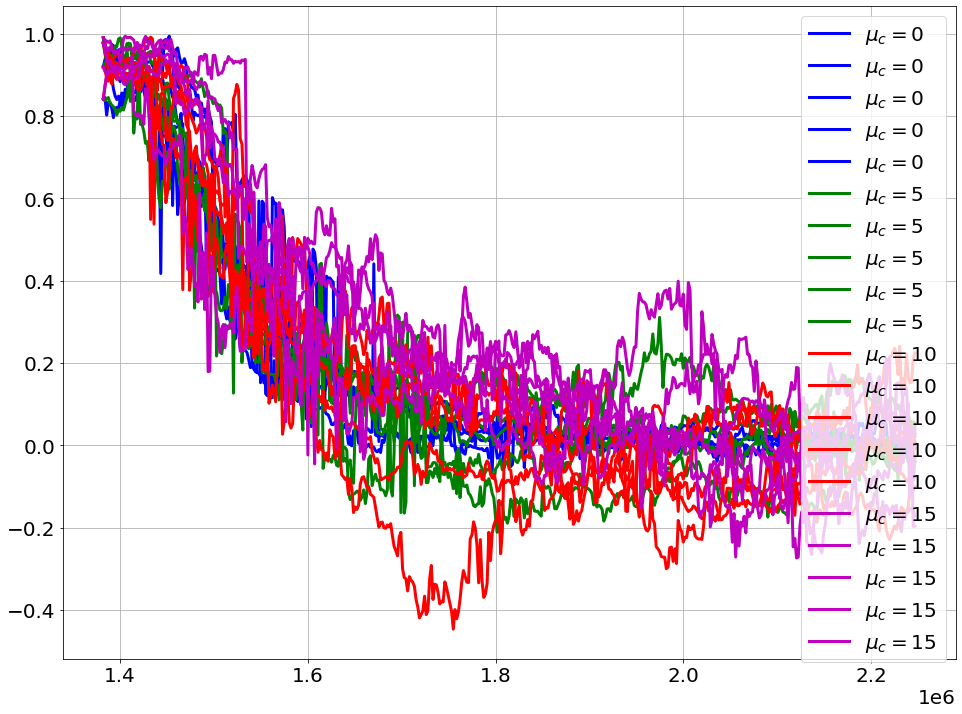

In [136]:
figure(figsize=(16,12))

for mu_c,color in zip([0,5,10,15],['b','g','r','m']):

    seq2=pn.Sequence()


    seq2.load_seq(seq)

    seq2+=fix_jitter(total_time=t,
           save_interval=ts,
            mu_c=mu_c,sigma_c=0,
             eta=eta,noise=1,number_of_neurons=number_of_neurons)

    try:
        seq2.run(display=None,display_hash=False,
                   time_between_display=10*hour)
    except KeyboardInterrupt:
        close()


    fname='sims/2023-01-05/test.asdf'
    pn.save(fname,seq2)
    R=Results(fname)

    result=R.get_max_responses()
    idx=R.t>seq.sims[0].total_time

    plot(R.t[idx],R.ODI[idx,:],color,label=r'$\mu_c=%d$' % mu_c);

    
legend()

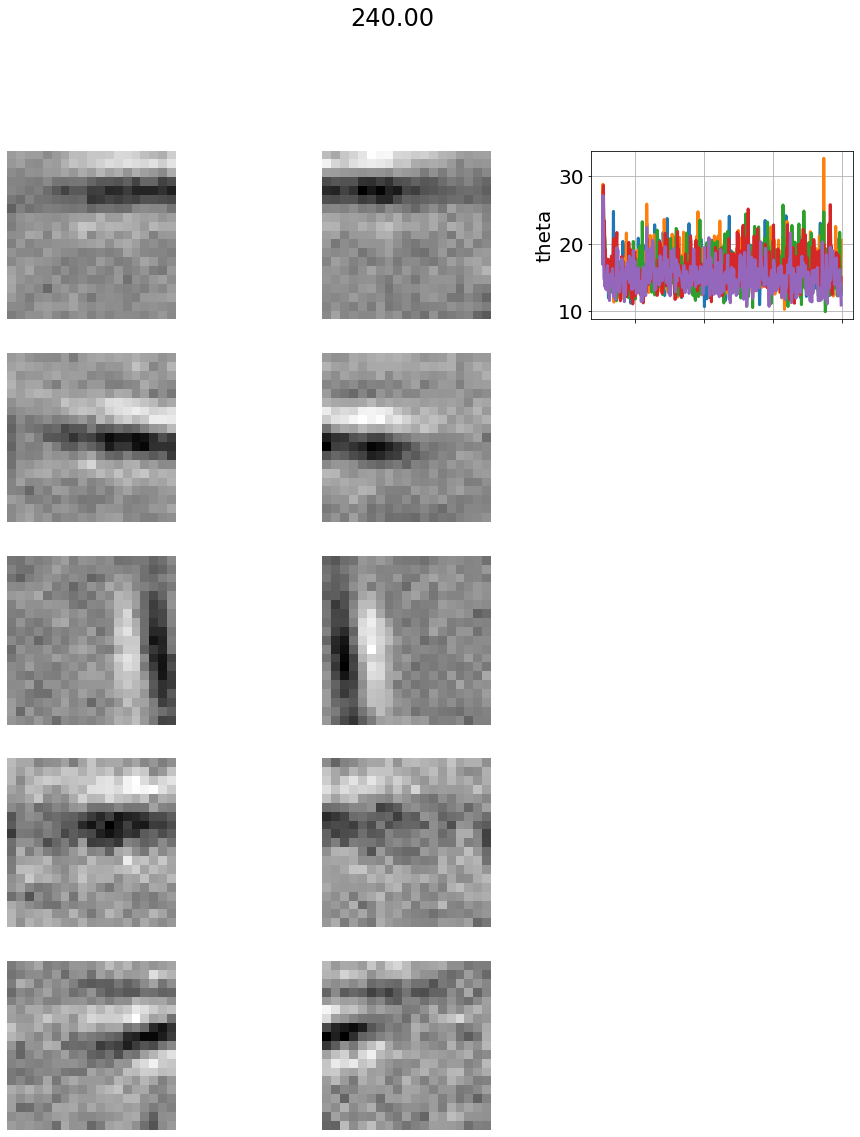

In [137]:
mydisplay(t,seq2.sims[-1],seq2.neurons[-1],seq2.connections[-1])

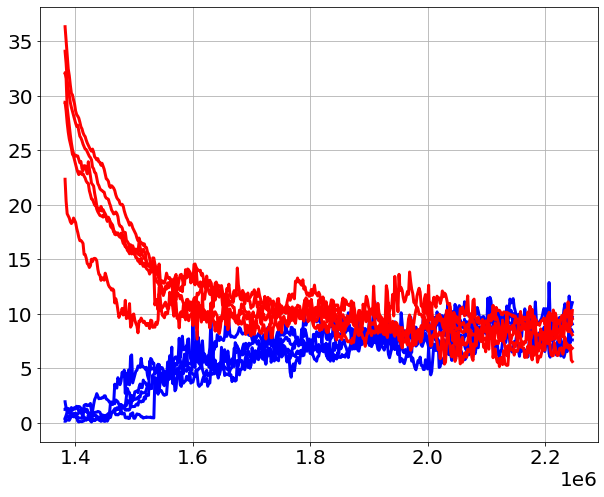

In [138]:
fname='sims/2023-01-05/test.asdf'
pn.save(fname,seq2)
R=Results(fname)

result=R.get_max_responses()
idx=R.t>seq.sims[0].total_time

plot(R.t[idx],R.y[idx,:,0],'b-')
plot(R.t[idx],R.y[idx,:,1],'r-');

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...40.98 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...44.22 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...44.49 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...42.48 s


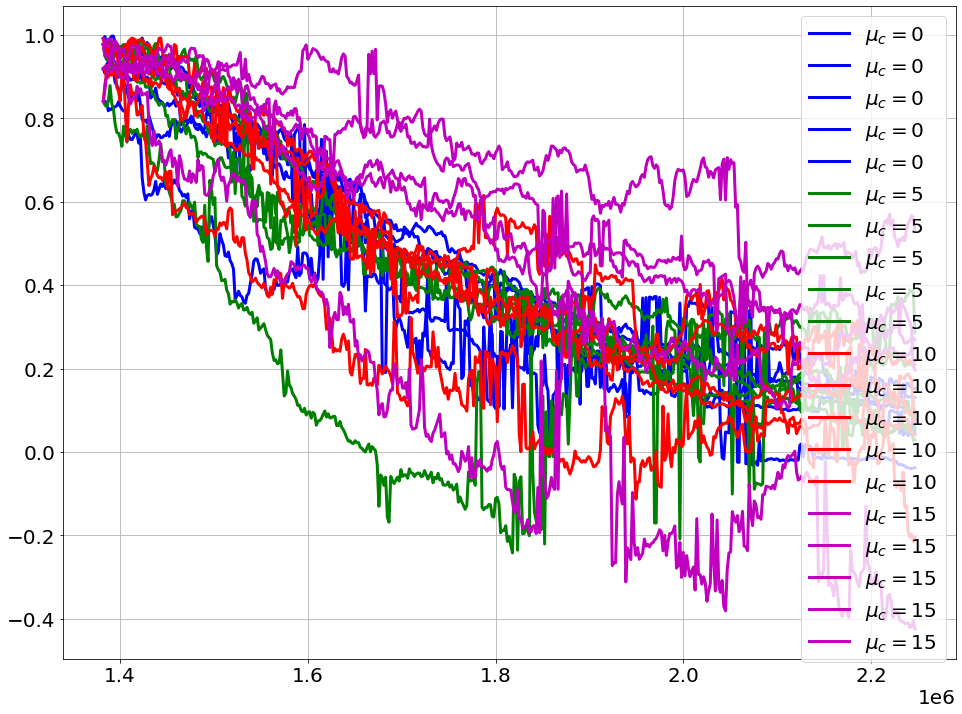

In [139]:
figure(figsize=(16,12))

for mu_c,color in zip([0,5,10,15],['b','g','r','m']):

    seq2=pn.Sequence()


    seq2.load_seq(seq)

    seq2+=fix_jitter(total_time=t,
           save_interval=ts,
            mu_c=mu_c,sigma_c=0,
             eta=eta,noise=0.5,number_of_neurons=number_of_neurons)

    try:
        seq2.run(display=None,display_hash=False,
                   time_between_display=10*hour)
    except KeyboardInterrupt:
        close()


    fname='sims/2023-01-05/test.asdf'
    pn.save(fname,seq2)
    R=Results(fname)

    result=R.get_max_responses()
    idx=R.t>seq.sims[0].total_time

    plot(R.t[idx],R.ODI[idx,:],color,label=r'$\mu_c=%d$' % mu_c);

    
legend()

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...46.13 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...44.32 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...44.11 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...43.96 s


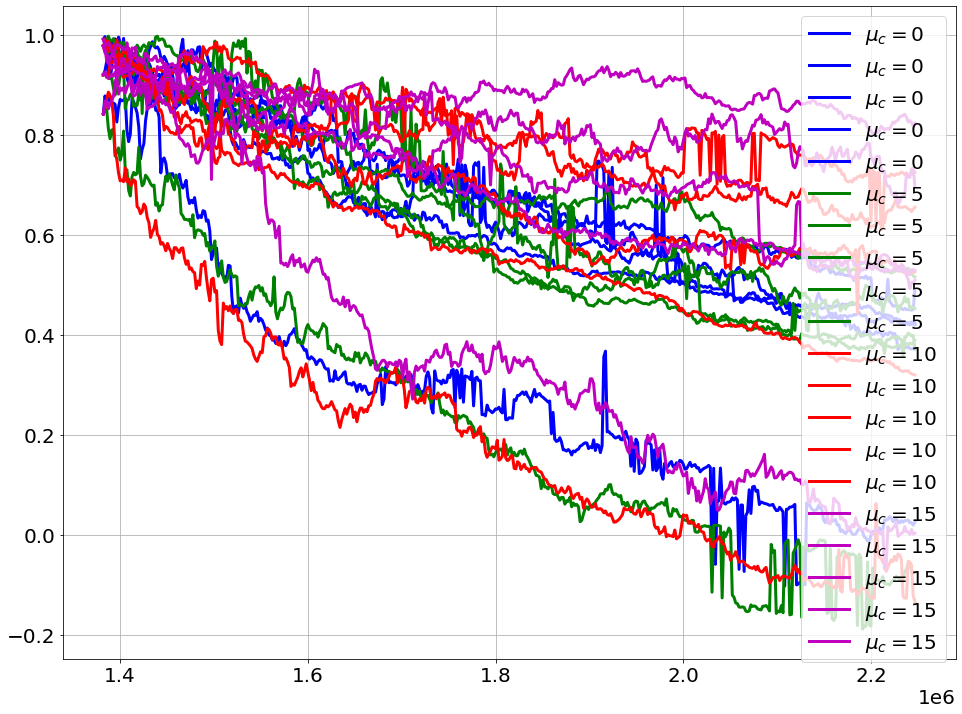

In [140]:
figure(figsize=(16,12))

for mu_c,color in zip([0,5,10,15],['b','g','r','m']):

    seq2=pn.Sequence()


    seq2.load_seq(seq)

    seq2+=fix_jitter(total_time=t,
           save_interval=ts,
            mu_c=mu_c,sigma_c=0,
             eta=eta,noise=0.2,number_of_neurons=number_of_neurons)

    try:
        seq2.run(display=None,display_hash=False,
                   time_between_display=10*hour)
    except KeyboardInterrupt:
        close()


    fname='sims/2023-01-05/test.asdf'
    pn.save(fname,seq2)
    R=Results(fname)

    result=R.get_max_responses()
    idx=R.t>seq.sims[0].total_time

    plot(R.t[idx],R.ODI[idx,:],color,label=r'$\mu_c=%d$' % mu_c);

    
legend()

## sigma_c

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...47.03 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...46.88 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...47.72 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.22 s


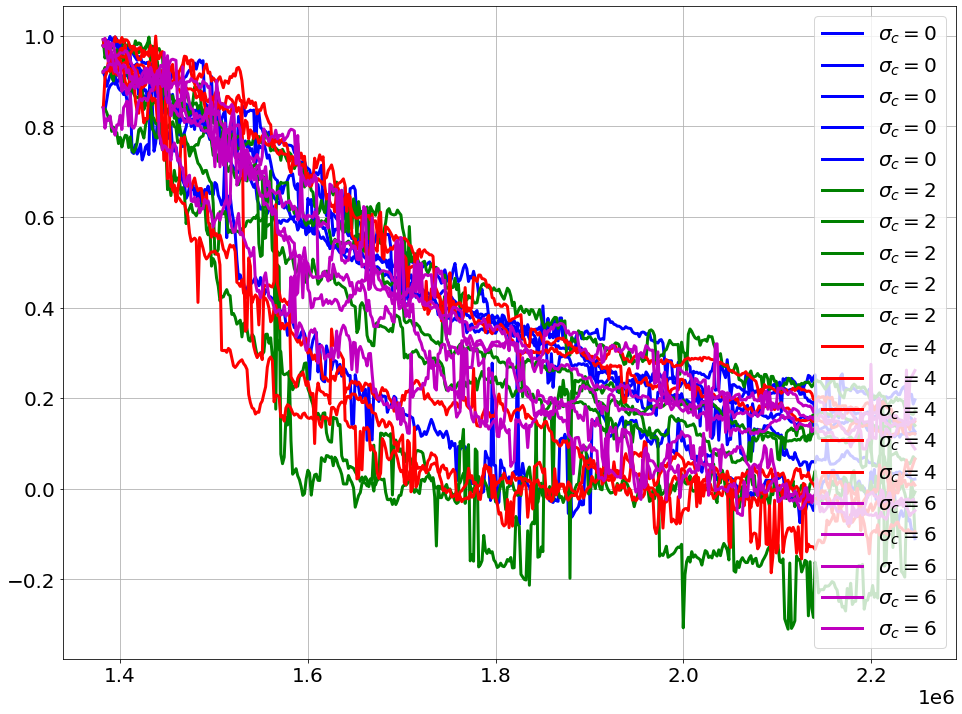

In [142]:
figure(figsize=(16,12))
mu_c=5

for sigma_c,color in zip([0,2,4,6],['b','g','r','m']):

    seq2=pn.Sequence()


    seq2.load_seq(seq)

    seq2+=fix_jitter(total_time=t,
           save_interval=ts,
            mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=0.5,number_of_neurons=number_of_neurons)

    try:
        seq2.run(display=None,display_hash=False,
                   time_between_display=10*hour)
    except KeyboardInterrupt:
        close()


    fname='sims/2023-01-05/test.asdf'
    pn.save(fname,seq2)
    R=Results(fname)

    result=R.get_max_responses()
    idx=R.t>seq.sims[0].total_time

    plot(R.t[idx],R.ODI[idx,:],color,label=r'$\sigma_c=%d$' % sigma_c);

    
legend()

Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...49.43 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.81 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.72 s
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[..] Sequence Time Elapsed...48.80 s


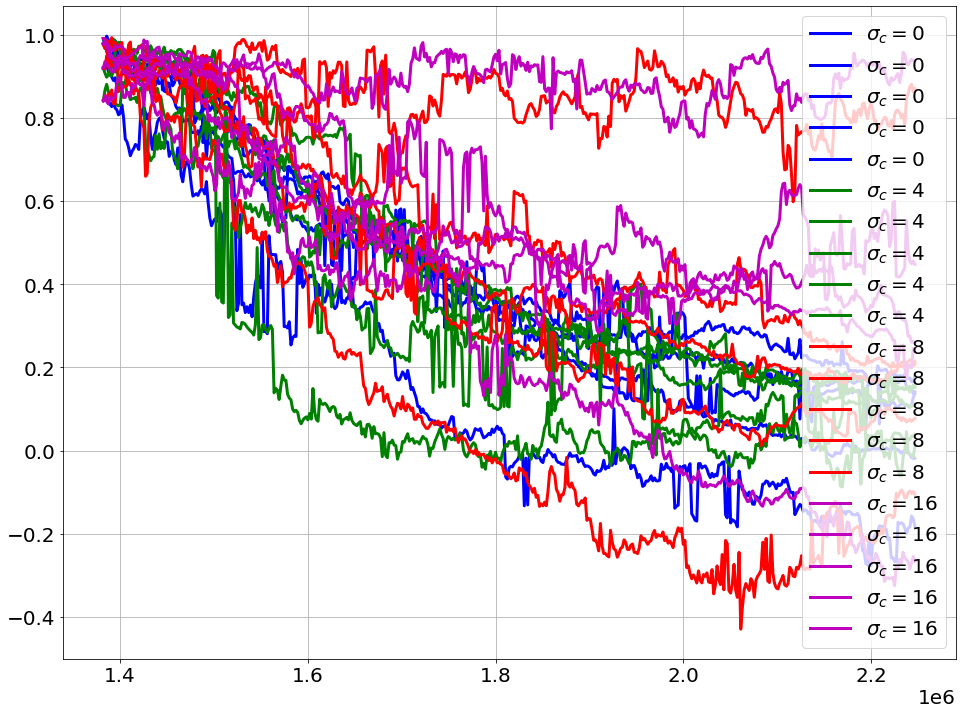

In [143]:
figure(figsize=(16,12))
mu_c=5

for sigma_c,color in zip([0,4,8,16],['b','g','r','m']):

    seq2=pn.Sequence()


    seq2.load_seq(seq)

    seq2+=fix_jitter(total_time=t,
           save_interval=ts,
            mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=0.5,number_of_neurons=number_of_neurons)

    try:
        seq2.run(display=None,display_hash=False,
                   time_between_display=10*hour)
    except KeyboardInterrupt:
        close()


    fname='sims/2023-01-05/test.asdf'
    pn.save(fname,seq2)
    R=Results(fname)

    result=R.get_max_responses()
    idx=R.t>seq.sims[0].total_time

    plot(R.t[idx],R.ODI[idx,:],color,label=r'$\sigma_c=%d$' % sigma_c);

    
legend()

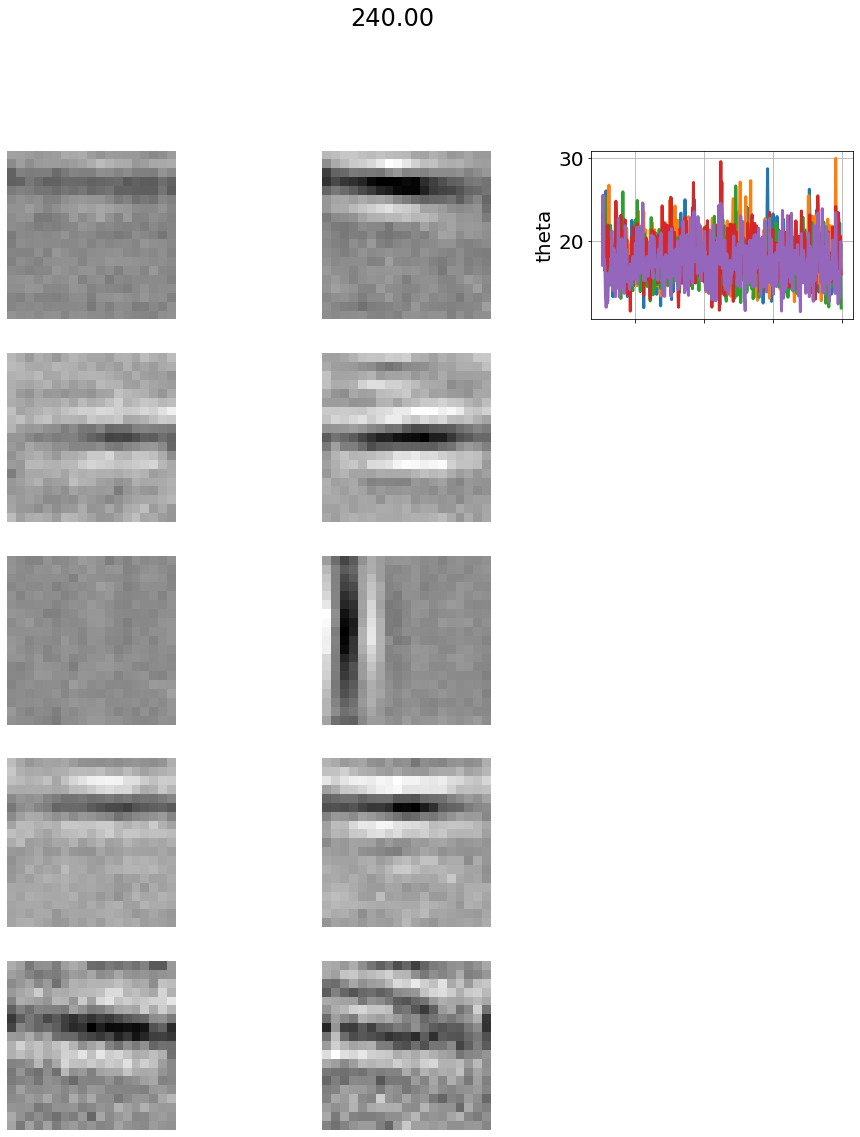

In [144]:
mydisplay(t,seq2.sims[-1],seq2.neurons[-1],seq2.connections[-1])